In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from datatile.summary.df import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.patches as mpatches

import warnings
from labellines import labelLine, labelLines
from scipy.signal import savgol_filter, find_peaks, find_peaks_cwt

warnings.filterwarnings('ignore')
plt.rcParams['image.interpolation'] = "None"
global colour 
colour = "black"
COLOR = colour
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams["legend.framealpha"] = 0

#### Reading in Image and Extracting Image Features

In [12]:
########### THIS IS FOR THE LAM OUTPUTS test = pd.read_parquet('0709_raw_intensity_with_distance.parquet')
#test = pd.read_parquet('C:\\Users\\isobe\Dropbox (The University of Manchester)\\Python\\Soft_Stiff_Experiment\\Finished_BM_localisation\\updated_all_lamintensity_with_distance.parquet')
test = pd.read_parquet("C:\\Users\\itayl\\Dropbox (The University of Manchester)\\Python\\Soft_Stiff_Experiment\\Finished_BM_localisation\\Final_Outputs_Collagen\\updated_all_colintensity_with_distance.parquet")
bm_type = "Collagen"
test.drop('index', axis=1, inplace=True)

In [13]:
# Scale each x between 0 and 1
test['max_distance'] = test.groupby('filename').rounded_distance.transform('max')
test['min_distance'] = test.groupby('filename').rounded_distance.transform('min')
test['rounded_distance'] = (test.rounded_distance - test.min_distance) / (test.max_distance - test.min_distance)
test.rounded_distance = test.rounded_distance.apply(lambda x: round(x, 2))
test = test[test["rounded_distance"] < 0.99]
# Scale each y between 0 and 1
test = test.merge(test.groupby('filename', as_index=False).bm_intensity.max().rename(columns={'bm_intensity': 'max_intensity'}))
test.bm_intensity = test.bm_intensity / test.max_intensity
average_intensity = test.groupby(['image_type', 'rounded_distance'], as_index=False).bm_intensity.mean()
average_intensity['mean_bm_intensity'] = average_intensity.groupby('image_type')["bm_intensity"].rolling(window=2).mean().droplevel(0)
test['bm_intensity'] = test.groupby('filename')["bm_intensity"].rolling(window=1).mean().droplevel(0)


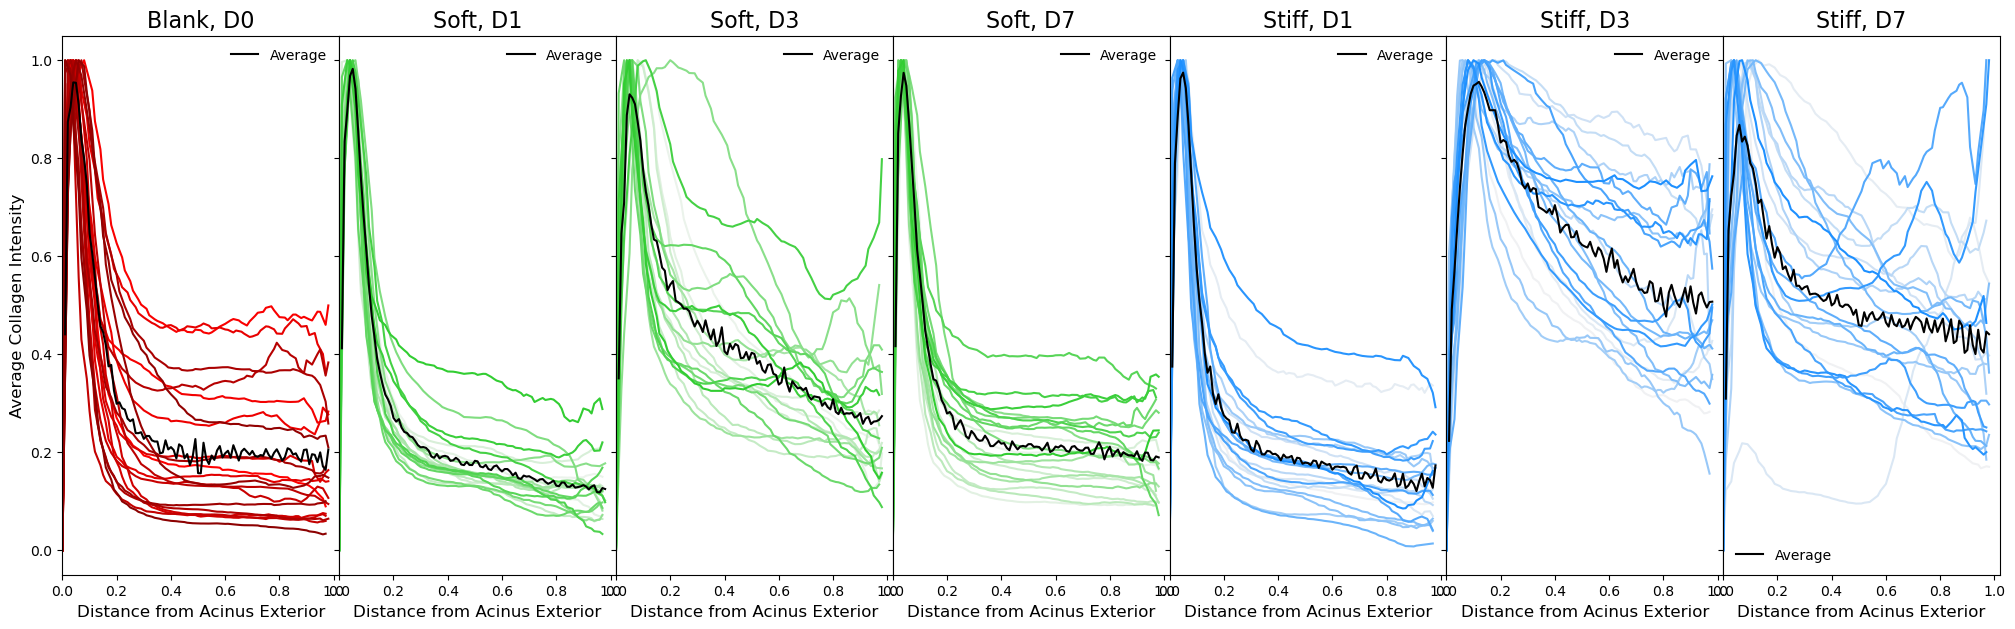

In [14]:
gridspec = dict(hspace=0.0, wspace=0, width_ratios=[1,1,1,1,1,1,1])
fig, axs = plt.subplots(ncols = test.image_type.unique().size, figsize = (25,7),  gridspec_kw = gridspec, sharey=True)
conditions = average_intensity.image_type.unique()
for i, condition in enumerate(conditions):
    if "blank" in condition:
        my_palette = "blend:#FF0000,#8C0101"
    elif "stiff" in condition:
       my_palette="light:#1E90FF"
    elif "soft" in condition:
        my_palette="light:#32CD32"
    sns.lineplot(data=test.loc[test["image_type"]==condition], x = "rounded_distance", y="bm_intensity", palette=my_palette, hue = "filename",  ax = axs[i],  alpha = 1, legend=None)

    sns.lineplot(data=average_intensity.loc[average_intensity["image_type"]==condition], x = "rounded_distance", y="mean_bm_intensity", color="k",  ax = axs[i], label="Average")
    axs[i].set_title(condition)
    #axs[i].legend(loc=2, prop={'size': 6})   
    axs[i].set_title(conditions[i].replace("_", " ").title(), fontsize=16)
    # axs[i].set_ylim(0.0,1.1)
    axs[i].set_xlim(0,1.02)

    for ax in axs:
        ax.set_xlabel("Distance from Acinus Exterior", fontsize=12)
        ax.set_ylabel("")
    axs[0].set_ylabel("Average {} Intensity".format(bm_type), fontsize=12)
    plt.savefig("{}_Changes.pdf".format(bm_type), bbox_inches = "tight", transparent = True)


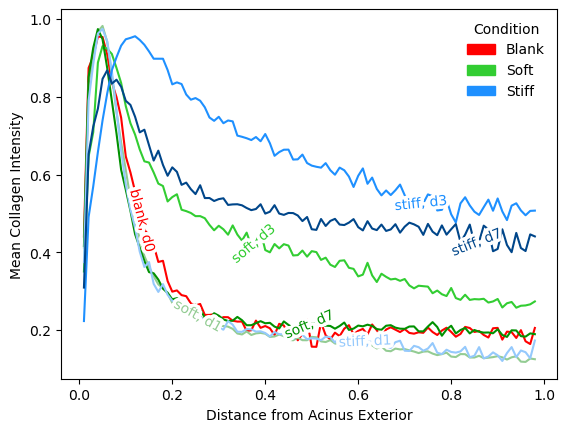

In [15]:
fig, ax = plt.subplots()
for i, condition in enumerate(average_intensity["image_type"].unique()):
    if "d0" in condition:
        colour = "red"
    elif "d1" in condition:
        if "stiff" in condition:
            colour="#95c9fc" #lightest blue
        else:
            colour= "#93cc93" #lightest green
    elif "d3" in condition:
        if "stiff" in condition:
            colour="dodgerblue" 
        else:
            colour= "limegreen" 
    else :
        if "stiff" in condition:
            colour="#00468a"  ## darkest blue
        else:
            colour= "#019101" #darkest green
        ## mid blue: dodgerblue
    sns.lineplot(data = average_intensity[average_intensity["image_type"]==condition], x="rounded_distance", y="mean_bm_intensity", color=colour, label=condition, legend=None)
labelLines(plt.gca().get_lines())
ax.set_ylabel("Mean {} Intensity".format(bm_type))
ax.set_xlabel("Distance from Acinus Exterior")
blank_patch = mpatches.Patch(color='red', label='Blank')
soft_patch = mpatches.Patch(color='limegreen', label='Soft')
stiff_patch = mpatches.Patch(color='dodgerblue', label='Stiff')
plt.legend(handles=[blank_patch, soft_patch, stiff_patch], title="Condition")
plt.savefig("Average_{}_Distances.pdf".format(bm_type), bbox_inches="tight", transparent=True)

#### Extracting Predictive Features

In [401]:
# Creating target variables

def category(row):
    if "d0" in row["Image"]:
        return "d0"
    elif "d1" in row["Image"]:
        if "soft" in row["Image"]:
            return "d1 Soft"
        else:
            return "d1 Stiff"
    elif "d3" in row["Image"]:
        if "soft" in row["Image"]:
            return "d3 Soft"
        else:
            return "d3 Stiff"  
    elif "d7" in row["Image"]:
        if "soft" in row["Image"]:
            return "d7 Soft"
        else:
            return "d7 Stiff"

categories = image_features.reset_index().apply(category, axis=1)
target_variables = pd.DataFrame()
target_variables['is_stiff'] = categories.apply(lambda x: 'Stiff' in x).astype(int)
target_variables['is_early'] = categories.apply(lambda x: 'd0' in x or 'd1' in x).astype(int)
target_variables['label'] = categories

In [443]:
image_features.drop(['pc_1', 'pc_2', 'Category'], axis=1, inplace=True)

In [446]:
rf = RandomForestClassifier(max_depth=2, min_samples_leaf=10)
rf.fit(image_features, target_variables['label'])
is_soft_features = set(pd.DataFrame(zip(image_features.columns, rf.feature_importances_), columns=['feature', 'importance']).sort_values('importance', ascending=False).iloc[:10].feature.values)

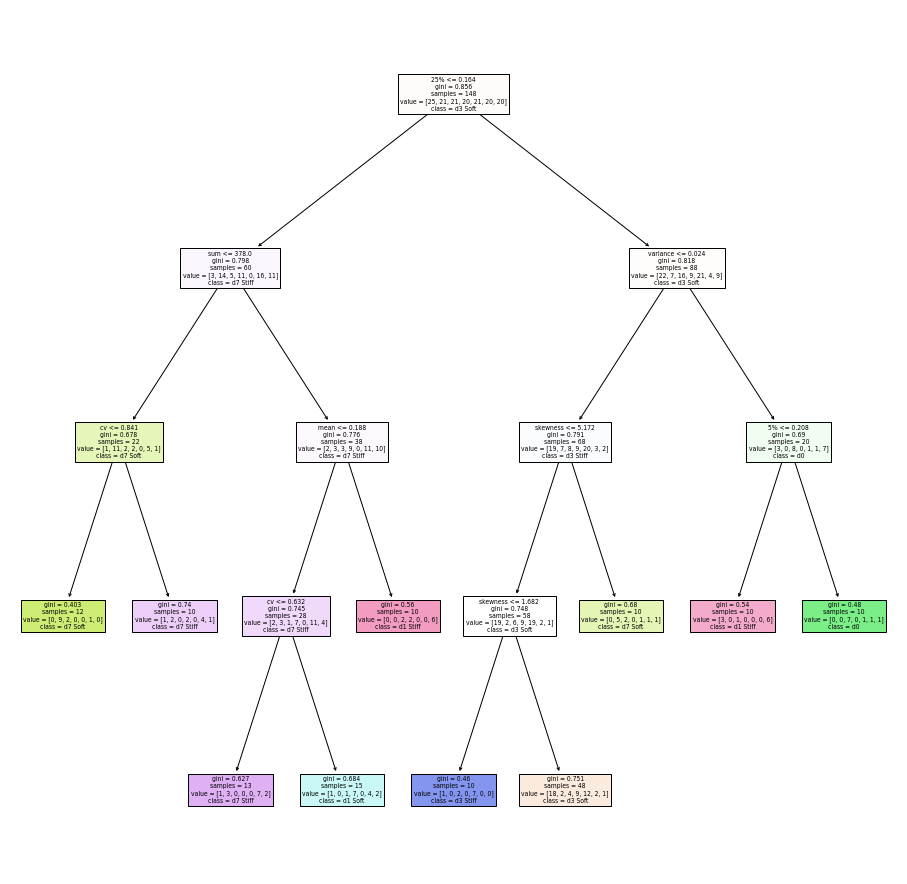

In [405]:
plt.figure(figsize=(16, 16))

_ = plot_tree(rf, 
                feature_names=image_features.columns,
                class_names=target_variables.label.unique(),
                   filled=True)

In [308]:
rf = DecisionTreeClassifier(max_depth=2, min_samples_leaf=10)
rf.fit(image_features, target_variables['is_early'])
is_early_features = set(pd.DataFrame(zip(image_features.columns, rf.feature_importances_), columns=['feature', 'importance']).sort_values('importance', ascending=False).iloc[:10].feature.values)

In [448]:
features = list(is_soft_features)

In [449]:
image_features = image_features[is_soft_features]

In [450]:
clusters = range(2, 21)
inertia = []

for i in clusters:
    kmeans = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=i))
    ])
    kmeans.fit(image_features)
    inertia.append(kmeans['kmeans'].inertia_)

Text(0.5, 0, 'Clusters')

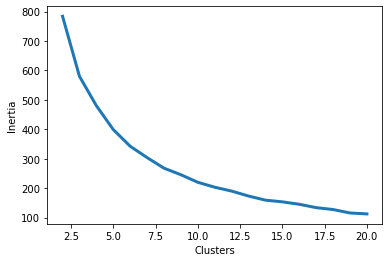

In [451]:
fig, ax = plt.subplots()
ax.plot(clusters, inertia, linewidth=3)
ax.set_ylabel('Inertia')
ax.set_xlabel('Clusters')

In [452]:
image_features.drop(['cluster', 'pc_1', 'pc_2', 'Category'], axis=1, inplace=True)

KeyError: "['cluster', 'pc_1', 'pc_2', 'Category'] not found in axis"

In [453]:
kmeans = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3))
])

kmeans.fit(image_features)
image_features['cluster'] = kmeans.predict(image_features)

In [454]:
cluster_assignment = image_features.reset_index()[['Image', 'cluster']]
total.drop('cluster', axis=1, inplace=True)
total = total.merge(cluster_assignment)

In [455]:
def plot_cluster_images(cluster):
    images_to_plot = np.random.choice(total[total.cluster == cluster].Image.unique(), 9)

    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))
    ax = ax.flatten()

    for i, image in enumerate(images_to_plot):
        image_specific_data = total[total.Image == image].set_index('Distance/Radius')
        # coefs_ = np.polyfit(image_specific_data.index, image_specific_data.Intensity, 3)
        # poly_vals = np.polyval(coefs_, image_specific_data.index)
        #ax[i].plot(image_specific_data.index, poly_vals )
        ax[i].set_title(image)
        image_specific_data.Intensity.plot(ax=ax[i])

    plt.tight_layout()

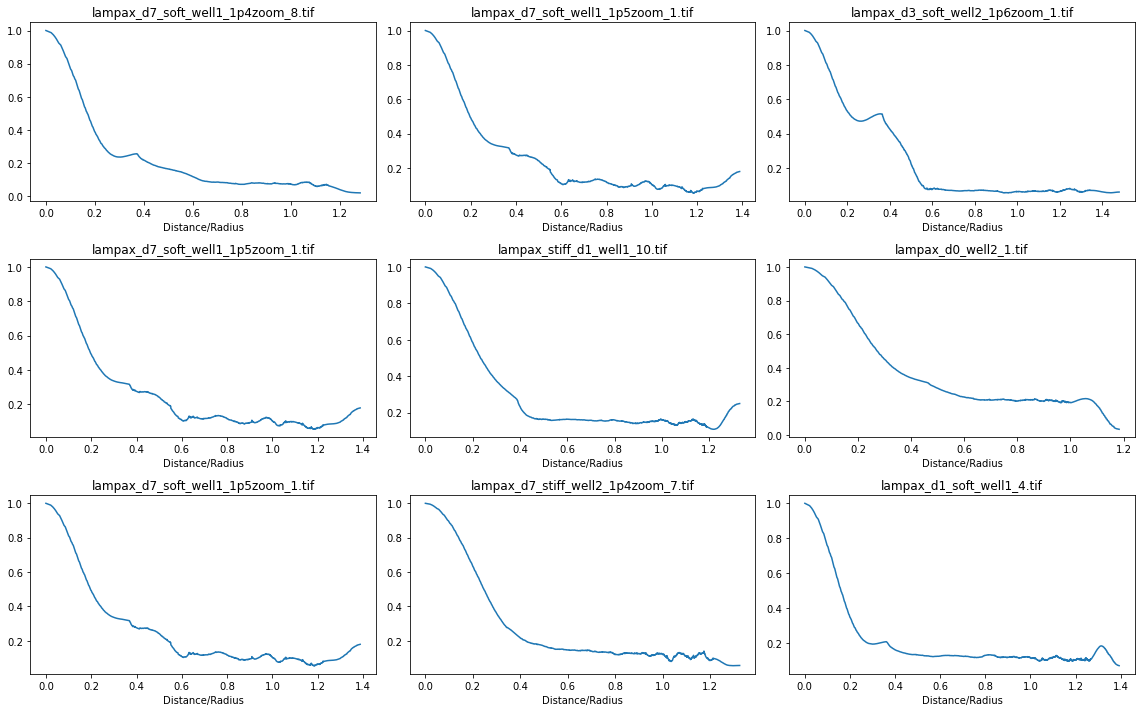

In [456]:
plot_cluster_images(0)

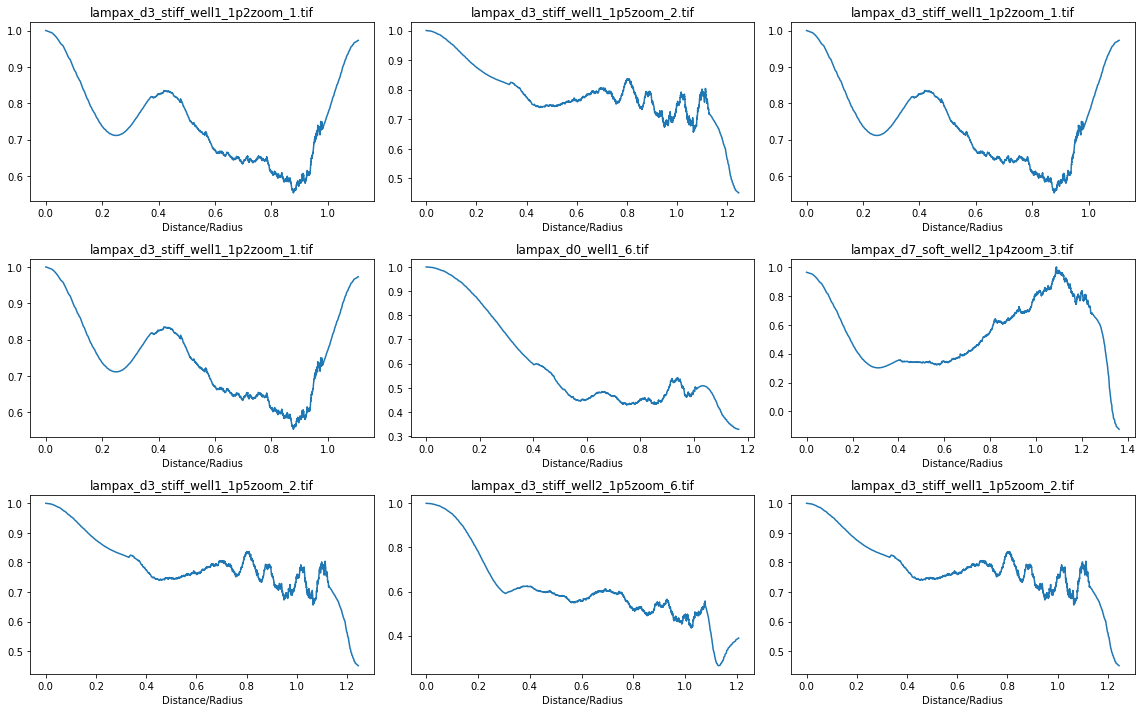

In [457]:
plot_cluster_images(1)

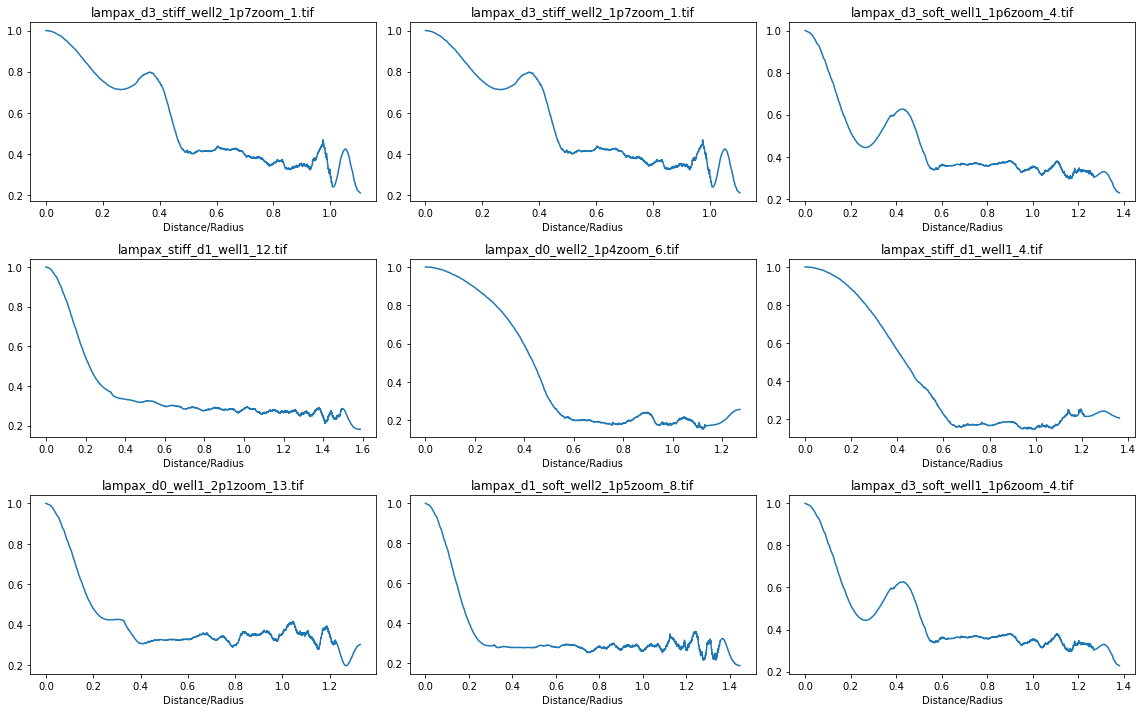

In [458]:
plot_cluster_images(2)

In [459]:
pca = Pipeline([
    ('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=2))
])

image_features[['pc_1', 'pc_2']] = pca.fit_transform(image_features.iloc[:, :-1])

<AxesSubplot:xlabel='pc_1', ylabel='pc_2'>

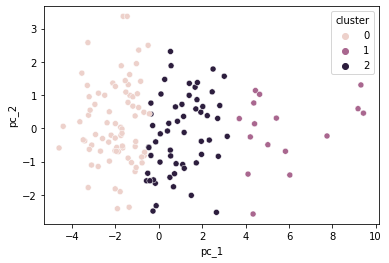

In [460]:
sns.scatterplot(data=image_features, x='pc_1', y='pc_2', hue='cluster')

In [461]:
def category(row):
    if "d0" in row["Image"]:
        return "d0"
    elif "d1" in row["Image"]:
        if "soft" in row["Image"]:
            return "d1 Soft"
        else:
            return "d1 Stiff"
    elif "d3" in row["Image"]:
        if "soft" in row["Image"]:
            return "d3 Soft"
        else:
            return "d3 Stiff"  
    elif "d7" in row["Image"]:
        if "soft" in row["Image"]:
            return "d7 Soft"
        else:
            return "d7 Stiff"

In [462]:
image_features['Category'] = image_features.reset_index().apply(category, axis=1).values

<AxesSubplot:xlabel='pc_1', ylabel='pc_2'>

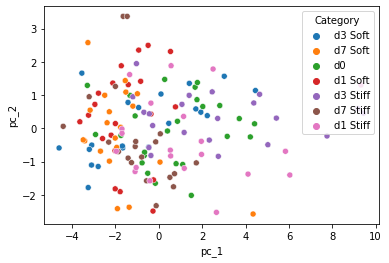

In [463]:
sns.scatterplot(data=image_features, x='pc_1', y='pc_2', hue='Category')

In [464]:
cluster_by_category = image_features.groupby(['cluster', 'Category']).size()
# cluster_by_category.name = 'size'

In [465]:
to_plot = pd.pivot_table(data=cluster_by_category.reset_index().rename(columns={0: 'Size'}), index='cluster', columns='Category', values='Size', aggfunc='sum').fillna(0)

In [466]:
to_plot

Category,d0,d1 Soft,d1 Stiff,d3 Soft,d3 Stiff,d7 Soft,d7 Stiff
cluster,,,,,,,
0,8.0,16.0,6.0,11.0,4.0,18.0,12.0
1,3.0,0.0,4.0,1.0,7.0,1.0,0.0
2,14.0,5.0,11.0,8.0,10.0,1.0,8.0
